# Fully Connected NN - Fish vs Cats

## 1. Import Libraries

In [1]:
import torch

## 2. Import data
- To import data using ImageFolder, we need our data to be stored in folder named as their labels.

### train_data

In [2]:
train_data_path = "Fish-vs-Cats/train"

- Define transforms.
- Use list of tranforms in compose.
- We are resizing our image to 64x64 pixels for efficient calculations.
- Then tranform pixel information to tensor.
- Normalize the tensor values between 0-1. Here, mean and SD are taken from mean and sd given in ImageNet for these images.

In [3]:
import torchvision
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                             std= [0.229, 0.224, 0.225])])

In [4]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_data_path, transform=transforms)
train_data.class_to_idx

{'cat': 0, 'fish': 1}

In [5]:
train_data

Dataset ImageFolder
    Number of datapoints: 800
    Root location: Fish-vs-Cats/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### val_data

In [6]:
val_data_path = "Fish-vs-Cats/val"

In [7]:
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=transforms)  # Apply same transform
val_data.class_to_idx

{'cat': 0, 'fish': 1}

In [8]:
val_data

Dataset ImageFolder
    Number of datapoints: 108
    Root location: Fish-vs-Cats/val
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### test_data

In [9]:
test_data_path = "Fish-vs-Cats/test"

In [10]:
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transforms)
test_data.class_to_idx

{'cat': 0, 'fish': 1}

In [11]:
test_data

Dataset ImageFolder
    Number of datapoints: 160
    Root location: Fish-vs-Cats/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## 3. Create dataloader batches

- To make the simulation faster we will give 64 image data at a time to our model.
- The model will perform actions for all the data in one batch parallely.

In [12]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=64)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

## 4. Initialize our model
- We will define a custom class derived from a parent class torch.nn.Module.
- Under our class we need to define init method for initializing nn layers.
- Then we will define forward method to connect these layers along with activation functions.

- super.__init__()- Purpose: Initializes the parent class (nn.Module) so your custom model can inherit its methods and functionality.
Without it: The custom model won't work correctly because essential features from nn.Module won't be initialized.


In [13]:
class SimpleNet(torch.nn.Module):
    def __init__(self):   # Define layers
        super(SimpleNet, self).__init__()
        self.fc1 = torch.nn.Linear(3*64*64, 84)  # First hidden layer (In features, Out features) 
        self.fc2 = torch.nn.Linear(84, 50) # Second hidden layer
        self.fc3 = torch.nn.Linear(50, 2)  # Output layer with 2 classes as output
    
    def forward(self, x):
        x = x.view(-1, 3*64*64)  # Flatten input tensor
        x = torch.nn.functional.relu(self.fc1(x))  # Output of first layer + activation function
        x = torch.nn.functional.relu(self.fc2(x))  # Output of second later + activation function
        x = self.fc3(x)  # Output of 3rd layer without activation function
        return x


- Output of third layer is not passed through the activation function because when we will use the CrossEntropyLoss loss function after output layer, it by deafaults used softmax() activation function. And we will use this in next step.

In [14]:
# Create the class instance

simplenet = SimpleNet()

# Define optimizer
- We will use adam optimizer.
- When using the Adam optimizer we provide an initial learning rate (e.g., lr=0.001). This learning rate serves as a baseline or starting point. Adam then adjusts the effective learning rate for each parameter during training based on its adaptive mechanism. 
- Optimizer will update the parameters from simplenet.parameters(): it contaings wieghts and biases tesnors stored in various layers.

In [15]:
optimizer = torch.optim.Adam(params= simplenet.parameters(),lr= 0.001)

# Training the model

In [16]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        training_loss = 0
        validation_loss = 0

        # Set model to training mode
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, target = batch
            output = model(inputs)
            loss = loss_fn(output, target) 
            loss.backward()   # Calculates gradient of loss function wrt weights and bias
            optimizer.step()  # Perform single optimization step to update parameter
            training_loss += loss.item()
        training_loss /= len(train_loader)

        # Set model to evaluation mode for validation
        model.eval()
        num_correct = 0
        num_examples = 0

        for batch in val_loader:
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            validation_loss += loss.item()
            correct = torch.eq( torch.max(torch.nn.functional.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

        validation_loss /= len(val_loader)

        print('Epoch:{}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss, validation_loss, num_correct/num_examples))



In [17]:
train(simplenet, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=20)

/var/folders/8y/my0b9w1110ldvlp3dqjw_49h0000gn/T/ipykernel_70209/4134627117.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq( torch.max(torch.nn.functional.softmax(output), dim=1)[1], targets).view(-1)


Epoch:0, Training Loss: 2.15, Validation Loss: 6.20, accuracy = 0.26
Epoch:1, Training Loss: 3.16, Validation Loss: 1.05, accuracy = 0.62
Epoch:2, Training Loss: 0.92, Validation Loss: 1.12, accuracy = 0.65
Epoch:3, Training Loss: 0.74, Validation Loss: 0.66, accuracy = 0.69
Epoch:4, Training Loss: 0.44, Validation Loss: 0.65, accuracy = 0.70
Epoch:5, Training Loss: 0.36, Validation Loss: 0.66, accuracy = 0.71
Epoch:6, Training Loss: 0.33, Validation Loss: 0.62, accuracy = 0.71
Epoch:7, Training Loss: 0.27, Validation Loss: 0.66, accuracy = 0.70
Epoch:8, Training Loss: 0.26, Validation Loss: 0.64, accuracy = 0.72
Epoch:9, Training Loss: 0.23, Validation Loss: 0.66, accuracy = 0.73
Epoch:10, Training Loss: 0.21, Validation Loss: 0.68, accuracy = 0.73
Epoch:11, Training Loss: 0.19, Validation Loss: 0.68, accuracy = 0.73
Epoch:12, Training Loss: 0.18, Validation Loss: 0.69, accuracy = 0.73
Epoch:13, Training Loss: 0.15, Validation Loss: 0.73, accuracy = 0.72
Epoch:14, Training Loss: 0.16,

# Make predictions

- Let's see how can we use python imaging library Pillow.

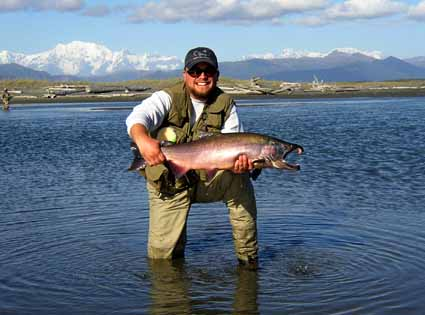

In [18]:
from PIL import Image

# Load an image
img = Image.open("Fish-vs-Cats/val/fish/tg_silver_tsiu_03.jpg")
img

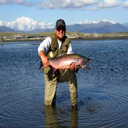

In [19]:
# Can perform various oprations
img_resize = img.resize((128,128))
img_resize

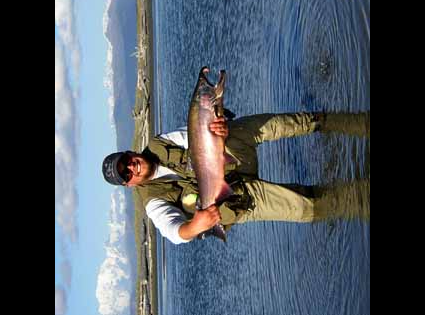

In [20]:
img_rotate = img.rotate(90)
img_rotate

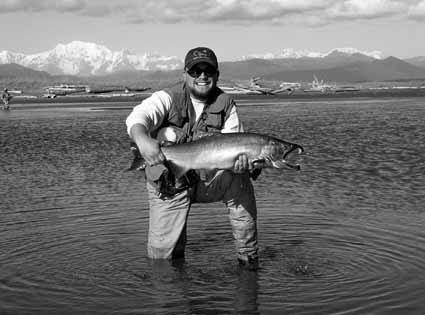

In [21]:
img_gray = img.convert("L")
img_gray

In [22]:
img.size

(425, 315)

In [23]:
img.format

'JPEG'

In [24]:
img.mode

'RGB'

In [25]:
img_resize.save('img_resize.JPG')

So, we can perform various operations using PIL module of python. And we will use this here for accessing single images to make predictions using our trained model.

In [26]:
from PIL import Image

labels = ['cat', 'fish']

img = Image.open("Fish-vs-Cats/val/fish/jimmy.jpg")
img = transforms(img)
img.shape

torch.Size([3, 64, 64])

- Our nn expects input with shape (batch_size, 3(for RGB), 64, 64).
- To make image of shape [1,3,64,64] for 1 image, we will unsqueeze it.

In [27]:
img = img.unsqueeze(0) # Adds one dimension at 0
img.shape

torch.Size([1, 3, 64, 64])

In [28]:
output = simplenet(img)
output

tensor([[-0.8417,  3.3632]], grad_fn=<AddmmBackward0>)

In [29]:
prediction = output.argmax(dim=0)
prediction

tensor([0, 0])

- Let's combine all above to create a prediction method.

In [30]:
from PIL import Image
from typing import List
import torch.nn as nn
from matplotlib import pyplot as plt
def predict(model: nn.Module,
            image_path: str,
            labels: List[str],
            transforms: torchvision.transforms.Compose) -> str:
    
    """ Predict class of given image
    """
    model.eval()
    img = Image.open(image_path)  # Load image
    img1 = transforms(img)  # Apply transforms
    img2 = img1.unsqueeze(0)  # Add a batch dimension (1, C, H, W)
    output = model(img2)
    prediction = output.argmax(dim=1).item()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{labels[prediction]}")


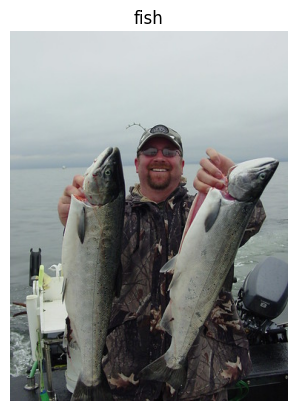

In [31]:
predict(simplenet, image_path="Fish-vs-Cats/test/fish/999386881_b6bbc2c39a.jpg", labels=['cat', 'fish'], transforms=transforms)

In [32]:
l = 0
correct = 0
for batch in test_data_loader:
    simplenet.eval()
    inputs, target = batch
    output = simplenet(inputs)
    predicted = output.argmax(dim=1)
    print(f"real={target}, \n pred= {predicted}")
    correct += torch.eq(target, predicted).sum()

acc = correct/len(test_data_loader.dataset)

print(f"accuracy= {acc}")


real=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 
 pred= tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1])
real=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 
 pred= tensor([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0])
real=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1,

## Saving the model

### Saving full model

In [33]:
torch.save(simplenet, "/tmp/simplenet")  # Save

In [34]:
torch.load("/tmp/simplenet")  # Reload

/var/folders/8y/my0b9w1110ldvlp3dqjw_49h0000gn/T/ipykernel_70209/1466036870.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("/tmp/simplenet")  # Reload


SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

**Problem with this?**
- Saves model structure and parameters.
- If we change the structure of model and try to load the saved one, error will generate.

### Saving only parameters

In [35]:
torch.save(simplenet.state_dict(), "simplenet_state_dict.pth" )  # Save state_dict

**Best practice**
- Save model's structure separately because we will need the model structure to load the model.

In [53]:
with open("simplenet_info.txt", "w") as f:
    f.write(str(simplenet))

In [ ]:
# Restore 
# Create model instance first then load

simplenet = SimpleNet()
state_dict = torch.load("simplenet_state_dict.pth")   # Saves weights and bias in dict format

/var/folders/8y/my0b9w1110ldvlp3dqjw_49h0000gn/T/ipykernel_70209/1926530032.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("simplenet_state_dict

In [50]:
state_dict['fc1.weight']  # e.g.

tensor([[-0.0072,  0.0009, -0.0062,  ...,  0.0126,  0.0001, -0.0020],
        [ 0.0030, -0.0006, -0.0066,  ..., -0.0036, -0.0110, -0.0027],
        [ 0.0041, -0.0007,  0.0055,  ...,  0.0045,  0.0019,  0.0053],
        ...,
        [ 0.0215,  0.0088,  0.0130,  ..., -0.0044,  0.0041, -0.0103],
        [ 0.0164,  0.0022,  0.0032,  ..., -0.0094, -0.0051, -0.0082],
        [ 0.0048,  0.0096, -0.0008,  ..., -0.0011, -0.0169, -0.0097]])

In [51]:
state_dict['fc1.bias']

tensor([ 0.0046,  0.0112, -0.0026,  0.0171, -0.0042,  0.0066,  0.0022,  0.0015,
        -0.0208, -0.0277, -0.0054, -0.0105, -0.0044, -0.0134, -0.0100, -0.0018,
        -0.0132, -0.0110, -0.0020,  0.0135, -0.0105, -0.0022, -0.0285, -0.0139,
        -0.0008, -0.0071, -0.0120,  0.0105, -0.0105,  0.0087, -0.0236, -0.0055,
        -0.0015,  0.0149,  0.0190, -0.0207,  0.0108, -0.0020, -0.0146,  0.0121,
        -0.0153, -0.0214, -0.0014,  0.0178, -0.0128, -0.0064, -0.0017,  0.0080,
        -0.0272, -0.0226, -0.0139, -0.0147, -0.0227, -0.0059, -0.0022, -0.0188,
        -0.0013,  0.0142, -0.0061, -0.0109,  0.0039,  0.0011, -0.0046, -0.0136,
         0.0099,  0.0035,  0.0011, -0.0064,  0.0114,  0.0015, -0.0138,  0.0038,
         0.0105, -0.0151, -0.0288, -0.0084, -0.0153, -0.0028,  0.0119, -0.0208,
        -0.0103, -0.0293,  0.0057, -0.0008])

In [38]:
simplenet.load_state_dict(state_dict)

<All keys matched successfully>

In [39]:
simplenet.eval()

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
predict 

<function __main__.predict(model: torch.nn.modules.module.Module, image_path: str, labels: List[str], transforms: torchvision.transforms.transforms.Compose) -> str>

In [54]:
import torch
import torch.nn as nn 
class CNNNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [56]:
cn = CNNNet()

In [57]:
train(cn, optimizer, torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=20)

/var/folders/8y/my0b9w1110ldvlp3dqjw_49h0000gn/T/ipykernel_70209/4134627117.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq( torch.max(torch.nn.functional.softmax(output), dim=1)[1], targets).view(-1)


Epoch:0, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:1, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:2, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:3, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:4, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:5, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:6, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:7, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:8, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:9, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:10, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:11, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:12, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:13, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.19
Epoch:14, Training Loss: 0.69,

KeyboardInterrupt: 